In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install python-bidi
!pip install gensim
!pip install python-dotenv

In [12]:
import pathlib
import os
import codecs
import csv
import json 
import requests
from collections import Counter
from datetime import datetime
from bidi import algorithm as bidialg
import numpy as np
import pandas as pd
import re
import pickle

# Gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

In [13]:
#### SETTING PATHS FOR THIS PROJECT ####

# Use this as base path if the project Files
# and the Notebook located in the same directory
base_path = pathlib.Path().absolute()

# Setting the name and path to the Output folder
output_path = os.path.join(base_path, "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Setting the name and path to the Resources folder
resources_path = os.path.join(base_path, "resources")


# functions below are for easing the access to files down the road
def get_resource_file_path(filename):
    return os.path.join(resources_path,"{}".format(filename))
        
def get_output_file_path(filename):
    return os.path.join(output_path,"{}".format(filename))

def get_file_content(file_path):
    with open(file_path, mode="r", encoding="utf-8") as infile:
         return json.load(infile)

In [97]:
# mypath = os.path.join(str(base_path.parent),"Step_2-Topic_Modeling","output")
mypath = resources_path
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['id2topic.txt',
 'laws_corpus_lemmatized.json',
 'laws_index.json',
 'laws_words_count.csv',
 'stopwords.txt']

In [15]:
#### LOAD RELEVANT FILES ####

# Set Path to the lemmatized corpus and load to memory
lemmatized_corpus_path = get_resource_file_path("laws_corpus_lemmatized.json")
lemmatized_corpus = get_file_content(lemmatized_corpus_path)

# Set Path to laws index and load to memory
laws_index_path = get_resource_file_path("laws_index.json")
laws_index = get_file_content(laws_index_path)

In [16]:
########      There is a file containing the word count for the lemmatized corpus       #########
########           in the 'resources' folder, called 'laws_words_count.csv'             #########
########               you should filter the stop words to your liking                  #########
########   Open up a new text file, and add all stopwords to this file, line-by-line    #########

In [17]:
# After grouping all stop words to a single file
# read the file to load the stopwords to memory
# {filepath}: the path to the file with the stop words
# @return: Set<string>
def get_stopwords(filepath):
    file = open(filepath, encoding='utf-8', mode='r')
    lines = file.readlines()
    lines = [line.strip() for line in lines]
    stopwords = set(lines)
    return stopwords

In [52]:
# Set the path to the stopwords text file
stopwords_path = get_resource_file_path("stopwords.txt")

# Loading stopwords to memory
stopwords = get_stopwords(stopwords_path)

In [53]:
# getting all laws and clean them for LDA
# removing stopwords and blanks, and concatenating 
# all lists that make a law to one big list
def get_cleaned_corpus(lemmatized_corpus):
    clean_corpus = []
    for document in lemmatized_corpus:
        clean_law = [word for word in document if word is not "" and word not in stopwords]
        if 0<len(clean_law):
            clean_corpus.append(clean_law)
        else:
            print(document)
    return clean_corpus

In [54]:
# Setting a clean_corpus to be used for the model
clean_corpus = get_cleaned_corpus(lemmatized_corpus)

['על', 'אף', 'ה', 'אמור']
['על', 'אף', 'ה', 'אמור']
['הוראה', 'על', 'אף', 'ה', 'אמור']
['ל', 'ה', 'עניין']
['הוראה']


In [55]:
###### Preparing objects for gensim model #####

# Create Dictionary
id2word = corpora.Dictionary(clean_corpus)

# Create Corpus
texts = clean_corpus

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [94]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# and extract to the project folder

# Setting up the folder path and adding as env variable
mallet_dir_path = get_resource_file_path("mallet-2.0.8")
os.environ['MALLET_HOME'] = mallet_dir_path

# Setting up the path to the mallet folder
mallet_path = os.path.join(mallet_dir_path,"bin","mallet") # update this path

In [95]:
######    For optimized results, we need to check a various of topic divisions ######
###### The compute_coherence_values function do just that, by generating the   ######
###### LDA model iteratively for a wide range of topic count that can then be  ######
######    used for comparison for picking the one with the highest score       ######

In [101]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=70, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

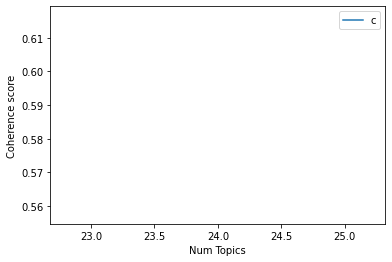

Num Topics = 24  has Coherence Value of 0.587


In [102]:
# Generating the model for a range of topic divisions

# Defining the range
start=24; limit=26; step=2;

# Running the model for this range
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=lemmatized_corpus, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

# Showing the results for choosing the optimal model
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [104]:
# Choose and Reference the optimal model in a variable
optimal_model = model_list[0] # Replace 0 with the right index

In [106]:
# Save the LDA model to an external file
with open(get_output_file_path('optimal_lda_model.pk'), 'wb') as lda_file:
    pickle.dump(optimal_model, lda_file)

In [107]:
# Load chosen LDA model if needed
# CHANGE the path if needed
with open(get_output_file_path('optimal_lda_model.pk'), 'rb') as lda_file:
    optimal_model = pickle.load(lda_file)

In [108]:
# Replace both values with the correspond values to the chosen model
num_topics=24; num_words=40; 

In [109]:
# Extracting topic words and put them in a list
# topic string is something like that: 
# '0.35*"one" + 0.085*"two" + 0.002*"three" +...'
# @return: ['one', 'two','three',...]
def __extract_words_from_topic_string(string):
    return [word for word in re.findall("\w+",string) if not re.match("\d", word)]

def __get_words_per_topic(topics):
    return [__extract_words_from_topic_string(topic[1]) for topic in topics]

In [110]:
# getting the topics list as strings
model_topics = optimal_model.print_topics(num_topics=num_topics, num_words=num_words)

# extracting the words list for each topic
topics_list = __get_words_per_topic(model_topics)

In [111]:
# Extract topics list to external CSV file
# For assigning each topic a title more conviniently

# {topics_path}: the path for the output file
# {topic_words_list}: the lists of words for each topic
# {num_words}: how many words from each topic to write
# @return: None
# @output: CSV file
def export_topics_to_csv(topics_path, topic_words_list, num_words):
    with open(topics_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        for i in range(num_words):
            writer.writerow([topic_words[i] for topic_words in topic_words_list])
        f.close()
            
# path for the desired output
topics_division_path = get_output_file_path("topics_divisions.csv")

# Export topics words to CSV file
export_topics_to_csv(topics_division_path, topics_list, num_words)

In [112]:
######      This step is for associating each topic id      ######
######           with a meaningful title             ######
######     it is recommended doing it in excel and then
######       copy the excel columns to a text file
######           format is: <topic_title> \t <id>
######   an example can be found in the 'resource' folder   ######

id2topic_path = get_resource_file_path('id2topic.txt')

# LOAD the associated topic for each index from external file
id2topic_file = open(id2topic_path, 'r', encoding='utf-8')
id2topic_lines = id2topic_file.readlines()
id2topic_file.close()
id2topic = {}
for line in id2topic_lines:
    split = re.split("\t",line.strip())
    if len(split) == 2:
        [topic, topic_id] = split
        id2topic[int(topic_id)-1] = topic.strip()

In [113]:
def __folder_path_to_date(date_str):
    try:
        x = re.search("\d+-\d+-\d+",date_str)
        return x.group()
    except:
        return ""

In [114]:
# Used for adding dates to each document, using
# the laws_index which is an ordered list
# of the path of each document in the 'akn' in 
# correspondence to each entry index in the DataFrame
def __add_dates_to_df(dominant_topic_df, include_relative_path = False):
    # Format to get Dominant Topic for Each
    dominant_topic_df = dominant_topic_df.reset_index()
    dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    dominant_topic_df['date'] = pd.Series(laws_index).map(__folder_path_to_date)
    if include_relative_path:
        dominant_topic_df['path'] = pd.Series(laws_index)
    return dominant_topic_df

# {include_topic_title} : adding the topic title to the DataFrame
# {include_topic_title} : adding the relative path to law to the DataFrame
# Based on the chosen model, it generates a table with  
# the dominant topic of each document in the corpus
def get_dominant_topic_df(ldamodel=optimal_model, corpus=corpus, texts=clean_corpus,
                          include_topic_title=False, include_relative_path = False):
    # Init output
    dominant_topic_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                dominant_topic_df = dominant_topic_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    dominant_topic_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    dominant_topic_df = pd.concat([dominant_topic_df, contents], axis=1)
    
    # Add the dates to the DataFrame by the index (path in 'akn' folder)
    dominant_topic_df = __add_dates_to_df(dominant_topic_df, include_relative_path)
    
    # Add the topic name to the DF
    if include_topic_title:
        dominant_topic_df['Topic'] = dominant_topic_df.apply (lambda row: id2topic[row['Dominant_Topic']], axis=1)
    return dominant_topic_df

In [115]:
dominant_topic_df = get_dominant_topic_df(optimal_model, corpus, texts,include_topic_title=True, include_relative_path = True)
dominant_topic_df

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,date,path,Topic
0,0,17.0,0.4383,"פקודה, עשה, מאסר, קנס, סימן, שטר, מעשה, תעודה,...","[יצירה, ייצא, לאור, יצר, יצירה, ייצא, לאור, גב...",1911-12-16,\PrimaryLegislation\1911-12-16\99999014\,ספנות
1,1,17.0,0.3160,"פקודה, עשה, מאסר, קנס, סימן, שטר, מעשה, תעודה,...","[אגודה, קבץ, מורכב, צירף, מתמיד, ידיעה, רץ, הש...",1914-05-11,\PrimaryLegislation\1914-05-11\2002137\,ספנות
2,2,17.0,0.3957,"פקודה, עשה, מאסר, קנס, סימן, שטר, מעשה, תעודה,...","[מלך, נקרא, מלך, הקיף, שטח, עלה, מונה, ארץ, לר...",1922-08-10,\PrimaryLegislation\1922-08-10\2001438\,ספנות
3,3,17.0,0.0958,"פקודה, עשה, מאסר, קנס, סימן, שטר, מעשה, תעודה,...","[מלך, נקרא, מלך, ארץ, קדוש, התעורר, נפל, גדר, ...",1924-07-25,\PrimaryLegislation\1924-07-25\2002080\,ספנות
4,4,17.0,0.2251,"פקודה, עשה, מאסר, קנס, סימן, שטר, מעשה, תעודה,...","[פקודה, קרא, זוג, יהודי, ביקש, נישא, נישואין, ...",1933-12-31,\PrimaryLegislation\1933-12-31\2001428\,ספנות
...,...,...,...,...,...,...,...,...
1943,1943,0.0,0.4903,"מזון, מוצר, יצרן, ייצור, יבואן, שיווק, תכשיר, ...","[חלב, מוצר, חלב, מקבילים, הכיל, רכיב, חלב, מוצ...",2019-03-26,\SecondaryLegislation\2019-03-26\53837\,"משפטים,ערכאות שיפוטיות"
1944,1944,11.0,0.8509,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[מערכה, סולרי, חימום, קלט, שטוח, מערכה, סולרי,...",2019-04-10,\SecondaryLegislation\2019-04-10\53864\,ביטחון הפנים
1945,1945,11.0,0.7848,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[פסולת, נייר, קרטון, גזם, פסולת, גינון, מזעור,...",2019-05-19,\SecondaryLegislation\2019-05-19\53930\,ביטחון הפנים
1946,1946,11.0,0.7011,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[מטרה, משתמש, בניין, סביבה, שהות, בטיחותי, צמצ...",2019-07-01,\SecondaryLegislation\2019-07-01\54009\,ביטחון הפנים


In [116]:
# {df}: the output of 'get_dominant_topic_df'
# {dates}: a list of tuples. each tuple
# is (start_date, end_date), dates are
# in format of yyyy-mm-dd
# @return: dominant_topic_df table with
# relevent dates only
def __filter_dates(df, dates):    
    filter_col = df['date'] == dates[0]
    for date_range in dates:
        start,end = date_range
        filter_col = filter_col | (start <= df['date']) & (df['date'] <= end)
    return df[filter_col]

In [130]:
# Tagging documents' topics for year 2012
filtered_dominant_topic_df = __filter_dates(dominant_topic_df, [('2000-02-28', '2021-02-28')])
filtered_dominant_topic_df

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,date,path,Topic
593,593,1.0,0.3655,"רפואי, בריאות, טיפול, ילד, קטין, רופא, חלה, כו...","[הבטיח, פעוט, מוגבלות, מסגרת, שיקומי, טיפולי, ...",2000-03-17,\PrimaryLegislation\2000-03-17\167825\,"חקלאות,מסחר בחקלאות,חומרים מסוכנים"
594,594,8.0,0.5031,"זכאי, סכום, קצבה, תשלום, חודש, ביטוח, שולם, גמ...","[שירת, אלול, התרצ, ספטמבר, לבין, באלול, התש, ב...",2000-04-09,\PrimaryLegislation\2000-04-09\167807\,דתות
595,595,10.0,0.4226,"הוגש, ערר, ערעור, תביעה, מסמך, הגשה, טענה, תוב...","[מטרה, הסמיך, הדרגתי, מחוזי, שבת, מנהלי, מנהלי...",2000-05-11,\PrimaryLegislation\2000-05-11\167858\,תקשורת
596,596,8.0,0.2304,"זכאי, סכום, קצבה, תשלום, חודש, ביטוח, שולם, גמ...","[זכאי, זקף, שבעה, היעדרות, כלל, רווחה, טיפול, ...",2000-06-11,\PrimaryLegislation\2000-06-11\169660\,דתות
597,597,3.0,0.2583,"ועדה, ממשלה, יושב, ישיבה, הכנסה, הצעה, כהונה, ...","[מטרה, שקד, שיקום, שילוב, קהילה, נכה, נפש, השי...",2000-07-06,\PrimaryLegislation\2000-07-06\168982\,"בטחון,משפט פלילי, משפט אזרחי,נזיקין"
...,...,...,...,...,...,...,...,...
1943,1943,0.0,0.4903,"מזון, מוצר, יצרן, ייצור, יבואן, שיווק, תכשיר, ...","[חלב, מוצר, חלב, מקבילים, הכיל, רכיב, חלב, מוצ...",2019-03-26,\SecondaryLegislation\2019-03-26\53837\,"משפטים,ערכאות שיפוטיות"
1944,1944,11.0,0.8509,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[מערכה, סולרי, חימום, קלט, שטוח, מערכה, סולרי,...",2019-04-10,\SecondaryLegislation\2019-04-10\53864\,ביטחון הפנים
1945,1945,11.0,0.7848,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[פסולת, נייר, קרטון, גזם, פסולת, גינון, מזעור,...",2019-05-19,\SecondaryLegislation\2019-05-19\53930\,ביטחון הפנים
1946,1946,11.0,0.7011,"חומר, מיתקן, מטר, מפעל, הותקן, מערכה, חשמל, בט...","[מטרה, משתמש, בניין, סביבה, שהות, בטיחותי, צמצ...",2019-07-01,\SecondaryLegislation\2019-07-01\54009\,ביטחון הפנים


In [131]:
# Generates a DataFrame with stats of
# documents count for each topic, and 
# their contribution to the mix in the corpus
# IMPORTANT: it makes use of 'id2topic'

# @input: a dominant_topic_df (filtered, or unfiltered)
def get_topic_distribution(dominant_topic_df):
    # Number of Documents for Each Topic
    topics_count = dominant_topic_df['Dominant_Topic'].value_counts()
    
    # Percentage of Documents for Each Topic
    topic_contribution = round(topics_count/topics_count.sum(), 4)

    topic_distibution = pd.concat([topics_count, topic_contribution], axis=1)
    topic_distibution = topic_distibution.reset_index()
    topic_distibution.columns = ['Dominant_Topic','Num_Documents', 'Perc_Documents']

    # Add the topic name to the DF
    if len(topics_count) == 0:
        topic_distibution['Topic'] = []
    else:
        topic_distibution['Topic'] = topic_distibution.apply (lambda row: id2topic[row['Dominant_Topic']], axis=1)
        
    return topic_distibution

In [132]:
topic_distribution_df = get_topic_distribution(filtered_dominant_topic_df)
topic_distribution_df

,Dominant_Topic,Num_Documents,Perc_Documents,Topic
0,21.0,74,0.0959,מסחר ותעשייה
1,3.0,62,0.0803,"בטחון,משפט פלילי, משפט אזרחי,נזיקין"
2,2.0,62,0.0803,"עבודה ורווחה,תעסוקה"
3,13.0,59,0.0764,ערכאות שיפוטיות
4,5.0,53,0.0687,בחירות
5,9.0,49,0.0635,בריאות
6,8.0,40,0.0518,דתות
7,18.0,38,0.0492,ניהול נכסים
8,22.0,34,0.0440,רשויות מקומיות
9,10.0,33,0.0427,תקשורת


In [133]:
# In case we'd want to add to the topics distribution, 
# topics that aren't present after filteration, we can use this function
# it adds all topics (from id2topic) but leave their
# contribution set to 0
def __add_missing_topics(df):
    existed_topic_ids = set(df['Dominant_Topic'].tolist())
    for topic_id in id2topic.keys():
        if topic_id not in existed_topic_ids:
            df = df.append({'Dominant_Topic':topic_id,'Num_Documents':0, 'Perc_Documents':0,'Topic':u'{}'.format(id2topic[topic_id])}, ignore_index=True)
    return df

In [134]:
# Saving the dominant_topic_df table to CSV if needed
dominant_topic_df.to_csv(get_output_file_path('dominant_topic_df.csv'), encoding='utf-8')

# Saving the topic_distribution table to CSV if needed
dominant_topic_df.to_csv(get_output_file_path('topic_distribution_df.csv'), encoding='utf-8')

In [135]:
# combinig the filtering and distribution to one
# easy-to-use function
def get_topics_distribution_by_dates(dominant_topic_df, dates=[]):
    
    if len(dates) != 0:
        dominant_topic_df = __filter_dates(dominant_topic_df, dates)

    return get_topic_distribution(dominant_topic_df)

In [136]:
# same result as shown previously when ran
# get_topic_distribution(filtered_dominant_topic_df)
get_topics_distribution_by_dates(dominant_topic_df, [('2012-01-01','2013-01-01')])

,Dominant_Topic,Num_Documents,Perc_Documents,Topic
0,9.0,5,0.1220,בריאות
1,18.0,4,0.0976,ניהול נכסים
2,0.0,4,0.0976,"משפטים,ערכאות שיפוטיות"
3,12.0,3,0.0732,בנקאות וכספים
4,8.0,3,0.0732,דתות
5,14.0,3,0.0732,תעופה
6,10.0,2,0.0488,תקשורת
7,16.0,2,0.0488,מיסוי
8,13.0,2,0.0488,ערכאות שיפוטיות
9,1.0,2,0.0488,"חקלאות,מסחר בחקלאות,חומרים מסוכנים"


In [137]:
# A Wrapper function for topic_distribution_df
# which gives you the option to choose if you want
# to add missing_topics and filter by date
# @return: DataFrame
def get_topics_data_table(dominant_topic_df=dominant_topic_df, missing_topics=True, dates=[]):

    topics_distribution = get_topics_distribution_by_dates(
        dominant_topic_df, dates)

    if missing_topics:
        topics_distribution = __add_missing_topics(topics_distribution)

    return topics_distribution

In [138]:
get_topics_data_table(dominant_topic_df=filtered_dominant_topic_df, missing_topics=True, dates=[])

,Dominant_Topic,Num_Documents,Perc_Documents,Topic
0,21.0,74,0.0959,מסחר ותעשייה
1,3.0,62,0.0803,"בטחון,משפט פלילי, משפט אזרחי,נזיקין"
2,2.0,62,0.0803,"עבודה ורווחה,תעסוקה"
3,13.0,59,0.0764,ערכאות שיפוטיות
4,5.0,53,0.0687,בחירות
5,9.0,49,0.0635,בריאות
6,8.0,40,0.0518,דתות
7,18.0,38,0.0492,ניהול נכסים
8,22.0,34,0.0440,רשויות מקומיות
9,10.0,33,0.0427,תקשורת


In [139]:
# A Wrapper function for get_topics_data_table
# that format the table as JSON object
# @return JSON, a list, each row is an object
def get_topics_data_json(dominant_topic_df=dominant_topic_df, missing_topics=True, dates=[]):
    res = []
    aggregated_dominant_topic_df = get_topics_data_table(
        dominant_topic_df, missing_topics=missing_topics, dates=dates)
    json_df = aggregated_dominant_topic_df.to_json(
        orient='index', force_ascii=False)
    json_df = json.loads(json_df)
    for key in json_df:
        res.append(json_df[key])
    return res

In [140]:
get_topics_data_json(dominant_topic_df=filtered_dominant_topic_df, missing_topics=True, dates=[])

[{'Dominant_Topic': 21.0,
  'Num_Documents': 74,
  'Perc_Documents': 0.0959,
  'Topic': 'מסחר ותעשייה'},
 {'Dominant_Topic': 3.0,
  'Num_Documents': 62,
  'Perc_Documents': 0.0803,
  'Topic': 'בטחון,משפט פלילי, משפט אזרחי,נזיקין'},
 {'Dominant_Topic': 2.0,
  'Num_Documents': 62,
  'Perc_Documents': 0.0803,
  'Topic': 'עבודה ורווחה,תעסוקה'},
 {'Dominant_Topic': 13.0,
  'Num_Documents': 59,
  'Perc_Documents': 0.0764,
  'Topic': 'ערכאות שיפוטיות'},
 {'Dominant_Topic': 5.0,
  'Num_Documents': 53,
  'Perc_Documents': 0.0687,
  'Topic': 'בחירות'},
 {'Dominant_Topic': 9.0,
  'Num_Documents': 49,
  'Perc_Documents': 0.0635,
  'Topic': 'בריאות'},
 {'Dominant_Topic': 8.0,
  'Num_Documents': 40,
  'Perc_Documents': 0.0518,
  'Topic': 'דתות'},
 {'Dominant_Topic': 18.0,
  'Num_Documents': 38,
  'Perc_Documents': 0.0492,
  'Topic': 'ניהול נכסים'},
 {'Dominant_Topic': 22.0,
  'Num_Documents': 34,
  'Perc_Documents': 0.044,
  'Topic': 'רשויות מקומיות'},
 {'Dominant_Topic': 10.0,
  'Num_Documents': 33

In [141]:
# Generating Horizontal Bar Chart to visualize the results
# {df} : DataFrame of type topic_distribution
# {ordered} : presenting the topics in descending order
# {missing_topics} : add missing topics to the chart
# @return: matplotlib plot
def get_topics_distribution_chart(df, ordered = False, missing_topics=True):
    # add missing values to DataFrame
    if missing_topics:
        df = __add_missing_topics(df)
    
    topics_count = df['Num_Documents'].tolist()
    topic_names = df['Topic'].map(lambda x: bidialg.get_display(u'{}'.format(x))).tolist()
    
    if ordered:
        topic_ids = list(range(0, len(topics_count)))
    else:
        topic_ids = df['Dominant_Topic'].tolist()
    
    fig, ax = plt.subplots()
    ax.barh(topic_ids, topics_count, align='center')
    ax.set_yticks(topic_ids)
    ax.set_yticklabels(topic_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Performance')
    ax.set_title('Topics Distribution')
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\sagi.levi\\.conda\\envs\\digital-humanities\\lib\\site-packages\\matplotlib\\pyplot.py'>

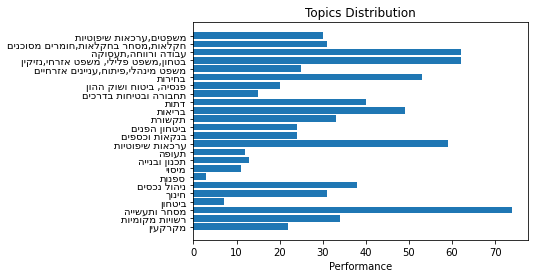

In [142]:
topics_distribution_chart = get_topics_distribution_chart(topic_distribution_df, ordered = False, missing_topics=True)
topics_distribution_chart